<a href="https://colab.research.google.com/github/kritisinghh/CNN/blob/main/Number_Plate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,930 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
pip install pytesseract opencv-python


Detected license plate number is: KA G2MP 9657



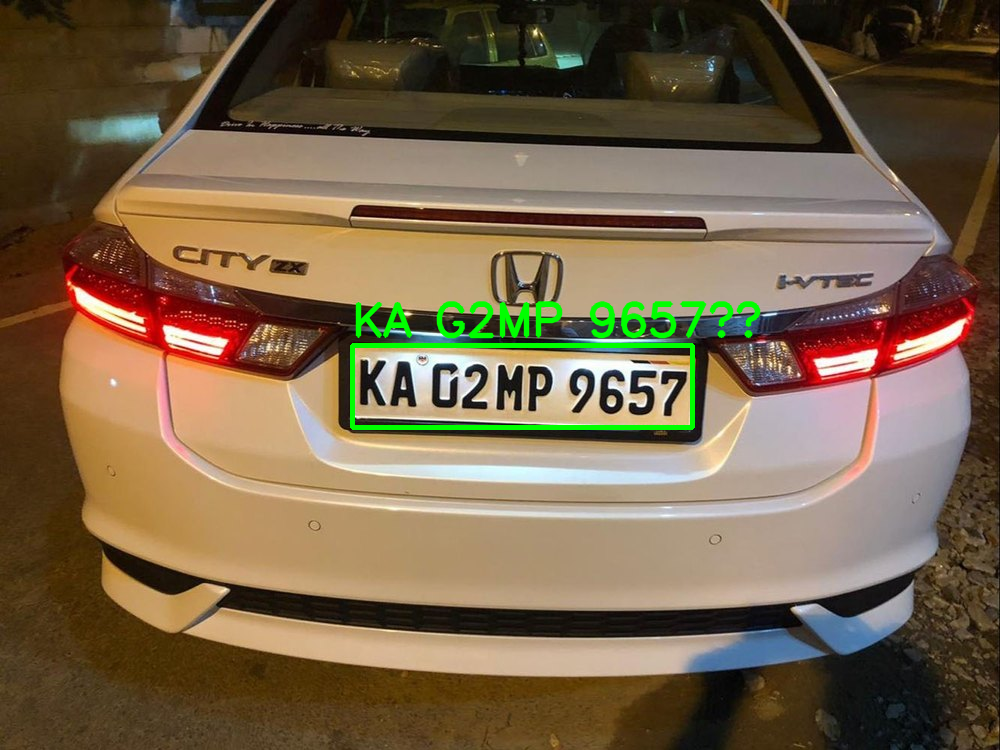

In [ ]:
import cv2
import pytesseract
import requests
import numpy as np
from google.colab.patches import cv2_imshow

# Path to the image
image_path = 'https://5.imimg.com/data5/SELLER/Default/2021/1/GH/QQ/WZ/120472934/car-ind-number-plate-1000x1000.jpeg'

# Load the image using requests
response = requests.get(image_path)
image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR) # Convert to OpenCV image

# Check if the image was loaded successfully
if image is None:
    print("Error: Could not load image.")
    exit()

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply some preprocessing
gray_image = cv2.bilateralFilter(gray_image, 11, 17, 17)  # Blur to reduce noise
edged = cv2.Canny(gray_image, 30, 200)  # Perform Edge detection

# Find contours based on edges detected
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours based on their area, keeping only the largest ones
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# Initialize a contour that corresponds to the license plate
plate_contour = None

# Loop over contours to find the best possible approximate contour of the license plate
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)

    if len(approx) == 4:  # Select the contour with 4 corners
        plate_contour = approx
        break

if plate_contour is None:
    print("No contour detected that resembles a license plate.")
else:
    # Masking the part other than the number plate
    mask = cv2.inRange(gray_image, 0, 255)
    new_image = cv2.bitwise_and(image, image, mask=mask)

    # Crop the rectangular part detected as the license plate
    x, y, w, h = cv2.boundingRect(plate_contour)
    cropped_image = gray_image[y:y + h, x:x + w]

    # Use Tesseract to do OCR on the cropped image
    text = pytesseract.image_to_string(cropped_image, config='--psm 8')
    print("Detected license plate number is:", text)

    # Display the original image with detected license plate text
    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Show the image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


Detected license plate number is: MH 14BR 6899


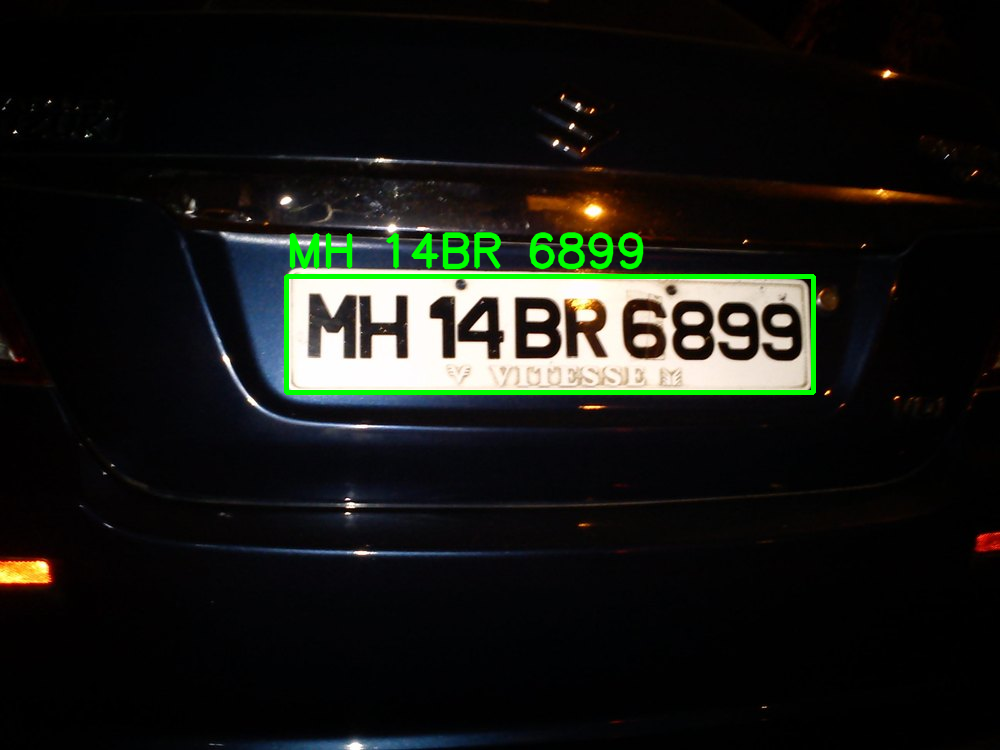

In [ ]:
import cv2
import pytesseract
import requests
import numpy as np
from google.colab.patches import cv2_imshow

# Function to preprocess the image
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 30, 200)
    return edged

# Function to find the plate contour
def find_plate_contour(edged):
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)
        if len(approx) == 4:
            return approx
    return None

# Function to extract text from the plate
def extract_plate_text(image, contour):
    x, y, w, h = cv2.boundingRect(contour)
    plate_image = image[y:y + h, x:x + w]

    # Additional preprocessing to improve OCR accuracy
    plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    _, plate_thresh = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    custom_config = r'--oem 3 --psm 7'  # Use a different OCR Engine mode and Page segmentation mode
    plate_text = pytesseract.image_to_string(plate_thresh, config=custom_config)

    return plate_text, (x, y, w, h)

# Main function
def main(image_url):
    # Load the image using requests
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)  # Convert to OpenCV image

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image.")
        return

    edged_image = preprocess_image(image)
    plate_contour = find_plate_contour(edged_image)

    if plate_contour is None:
        print("No contour detected that resembles a license plate.")
        return

    plate_text, (x, y, w, h) = extract_plate_text(image, plate_contour)
    print("Detected license plate number is:", plate_text.strip())

    cv2.putText(image, plate_text.strip(), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Show the image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# URL to the image
image_url = 'https://2.imimg.com/data2/FV/AP/MY-3387647/dsc00587-1000x1000.jpg'
main(image_url)


Detected license plate number is: 6 J01HU6963


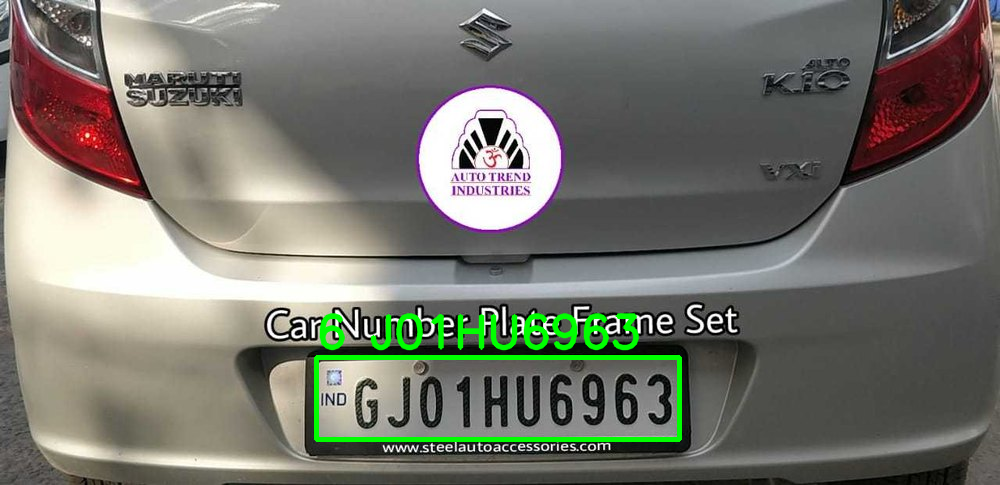

In [ ]:
import cv2
import pytesseract
import requests
import numpy as np
from google.colab.patches import cv2_imshow

# Function to preprocess the image
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 30, 200)
    return edged

# Function to find the plate contour
def find_plate_contour(edged):
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)
        if len(approx) == 4:
            return approx
    return None

# Function to extract text from the plate
def extract_plate_text(image, contour):
    x, y, w, h = cv2.boundingRect(contour)
    plate_image = image[y:y + h, x:x + w]

    # Additional preprocessing to improve OCR accuracy
    plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    _, plate_thresh = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    custom_config = r'--oem 3 --psm 7'  # Use a different OCR Engine mode and Page segmentation mode
    plate_text = pytesseract.image_to_string(plate_thresh, config=custom_config)

    return plate_text, (x, y, w, h)

# Main function
def main(image_url):
    # Load the image using requests
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)  # Convert to OpenCV image

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image.")
        return

    edged_image = preprocess_image(image)
    plate_contour = find_plate_contour(edged_image)

    if plate_contour is None:
        print("No contour detected that resembles a license plate.")
        return

    plate_text, (x, y, w, h) = extract_plate_text(image, plate_contour)
    print("Detected license plate number is:", plate_text.strip())

    cv2.putText(image, plate_text.strip(), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Show the image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# URL to the image
image_url = 'https://5.imimg.com/data5/FM/WI/MY-3048934/car-number-plate-frame-1000x1000.jpeg'
main(image_url)


Detected license plate number is: '~HR26DK8337|


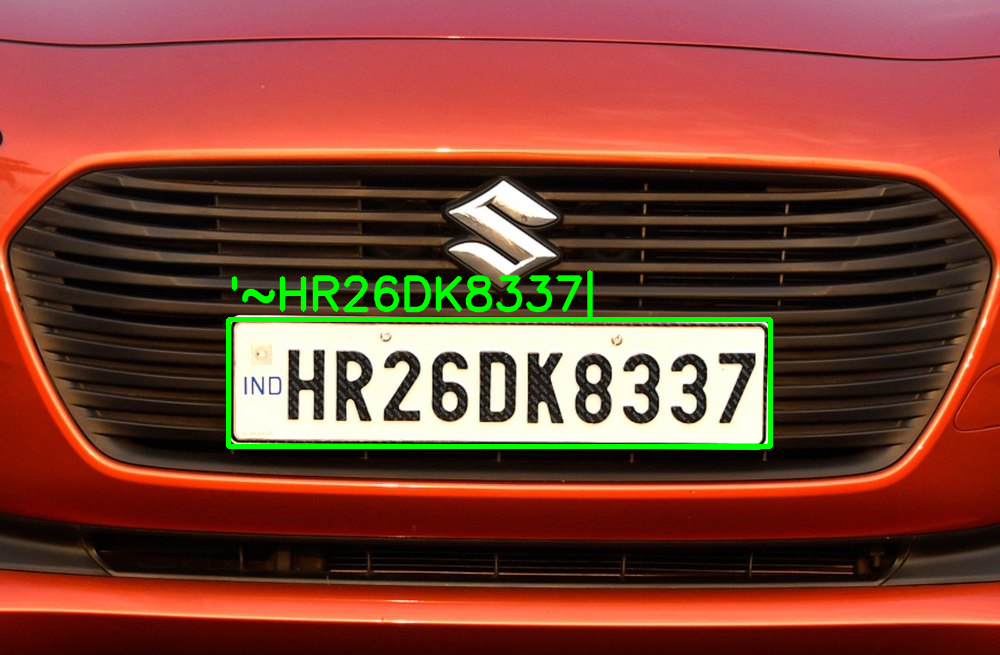

In [ ]:
import cv2
import pytesseract
import requests
import numpy as np
from google.colab.patches import cv2_imshow

# Function to preprocess the image
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 30, 200)
    return edged

# Function to find the plate contour
def find_plate_contour(edged):
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)
        if len(approx) == 4:
            return approx
    return None

# Function to extract text from the plate
def extract_plate_text(image, contour):
    x, y, w, h = cv2.boundingRect(contour)
    plate_image = image[y:y + h, x:x + w]

    # Additional preprocessing to improve OCR accuracy
    plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    _, plate_thresh = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    custom_config = r'--oem 3 --psm 7'  # Use a different OCR Engine mode and Page segmentation mode
    plate_text = pytesseract.image_to_string(plate_thresh, config=custom_config)

    return plate_text, (x, y, w, h)

# Main function
def main(image_url):
    # Load the image using requests
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)  # Convert to OpenCV image

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image.")
        return

    edged_image = preprocess_image(image)
    plate_contour = find_plate_contour(edged_image)

    if plate_contour is None:
        print("No contour detected that resembles a license plate.")
        return

    plate_text, (x, y, w, h) = extract_plate_text(image, plate_contour)
    print("Detected license plate number is:", plate_text.strip())

    cv2.putText(image, plate_text.strip(), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Show the image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# URL to the image
image_url = 'https://5.imimg.com/data5/SELLER/Default/2020/12/OJ/BG/YT/22341463/car-number-plate-1000x1000.jpg'
main(image_url)


Detected license plate number is: MH13 BN 8454


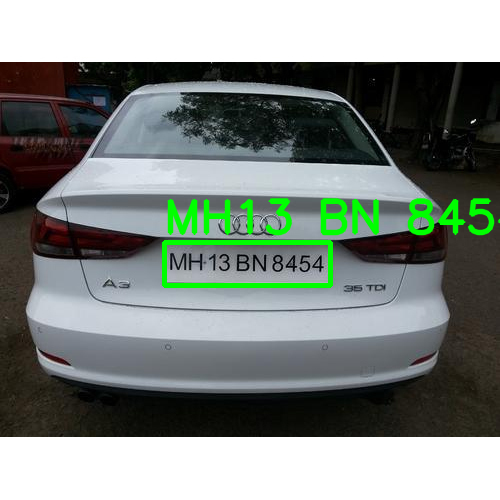

In [ ]:
import cv2
import pytesseract
import requests
import numpy as np
from google.colab.patches import cv2_imshow

# Function to preprocess the image
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 30, 200)
    return edged

# Function to find the plate contour
def find_plate_contour(edged):
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)
        if len(approx) == 4:
            return approx
    return None

# Function to extract text from the plate
def extract_plate_text(image, contour):
    x, y, w, h = cv2.boundingRect(contour)
    plate_image = image[y:y + h, x:x + w]

    # Additional preprocessing to improve OCR accuracy
    plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    _, plate_thresh = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    custom_config = r'--oem 3 --psm 7'  # Use a different OCR Engine mode and Page segmentation mode
    plate_text = pytesseract.image_to_string(plate_thresh, config=custom_config)

    return plate_text, (x, y, w, h)

# Main function
def main(image_url):
    # Load the image using requests
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)  # Convert to OpenCV image

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image.")
        return

    edged_image = preprocess_image(image)
    plate_contour = find_plate_contour(edged_image)

    if plate_contour is None:
        print("No contour detected that resembles a license plate.")
        return

    plate_text, (x, y, w, h) = extract_plate_text(image, plate_contour)
    print("Detected license plate number is:", plate_text.strip())

    cv2.putText(image, plate_text.strip(), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Show the image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# URL to the image
image_url = 'https://5.imimg.com/data5/GW/ES/MY-13535092/chrome-car-number-plate-1000x1000.jpg'
main(image_url)


Detected license plate number is: “MH13BK8100


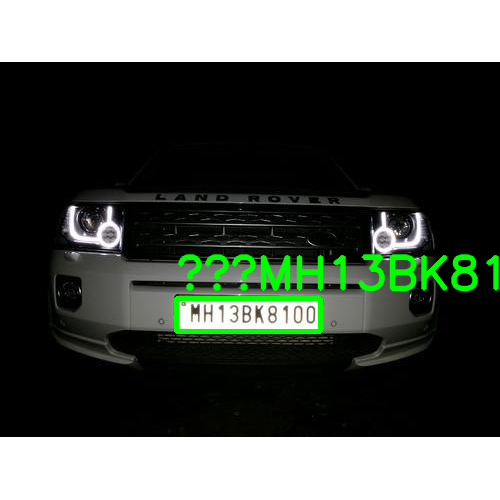

In [ ]:
import cv2
import pytesseract
import requests
import numpy as np
from google.colab.patches import cv2_imshow

# Function to preprocess the image
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 30, 200)
    return edged

# Function to find the plate contour
def find_plate_contour(edged):
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)
        if len(approx) == 4:
            return approx
    return None

# Function to extract text from the plate
def extract_plate_text(image, contour):
    x, y, w, h = cv2.boundingRect(contour)
    plate_image = image[y:y + h, x:x + w]

    # Additional preprocessing to improve OCR accuracy
    plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    _, plate_thresh = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    custom_config = r'--oem 3 --psm 7'  # Use a different OCR Engine mode and Page segmentation mode
    plate_text = pytesseract.image_to_string(plate_thresh, config=custom_config)

    return plate_text, (x, y, w, h)

# Main function
def main(image_url):
    # Load the image using requests
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)  # Convert to OpenCV image

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image.")
        return

    edged_image = preprocess_image(image)
    plate_contour = find_plate_contour(edged_image)

    if plate_contour is None:
        print("No contour detected that resembles a license plate.")
        return

    plate_text, (x, y, w, h) = extract_plate_text(image, plate_contour)
    print("Detected license plate number is:", plate_text.strip())

    cv2.putText(image, plate_text.strip(), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Show the image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# URL to the image
image_url = 'https://5.imimg.com/data5/FX/RH/MY-13535092/orbiz-number-plate-1000x1000.jpg'
main(image_url)


Detected license plate number is: " MH13BK8 100)


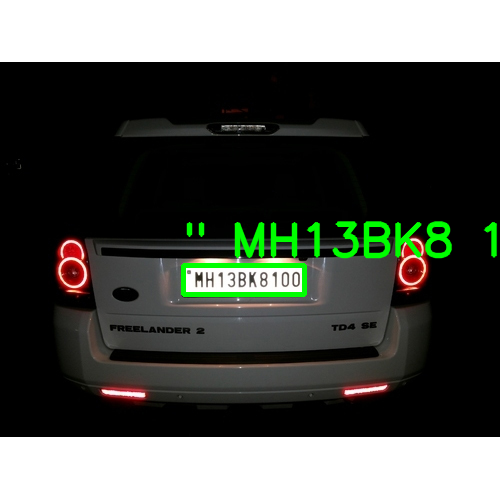

In [ ]:
import cv2
import pytesseract
import requests
import numpy as np
from google.colab.patches import cv2_imshow

# Function to preprocess the image
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 30, 200)
    return edged

# Function to find the plate contour
def find_plate_contour(edged):
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)
        if len(approx) == 4:
            return approx
    return None

# Function to extract text from the plate
def extract_plate_text(image, contour):
    x, y, w, h = cv2.boundingRect(contour)
    plate_image = image[y:y + h, x:x + w]

    # Additional preprocessing to improve OCR accuracy
    plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    _, plate_thresh = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    custom_config = r'--oem 3 --psm 7'  # Use a different OCR Engine mode and Page segmentation mode
    plate_text = pytesseract.image_to_string(plate_thresh, config=custom_config)

    return plate_text, (x, y, w, h)

# Main function
def main(image_url):
    # Load the image using requests
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)  # Convert to OpenCV image

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image.")
        return

    edged_image = preprocess_image(image)
    plate_contour = find_plate_contour(edged_image)

    if plate_contour is None:
        print("No contour detected that resembles a license plate.")
        return

    plate_text, (x, y, w, h) = extract_plate_text(image, plate_contour)
    print("Detected license plate number is:", plate_text.strip())

    cv2.putText(image, plate_text.strip(), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Show the image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# URL to the image
image_url = 'https://5.imimg.com/data5/IE/WP/MY-13535092/orbiz-font-car-number-plate-1000x1000.jpg'
main(image_url)


Detected license plate number is: " MH13BK8 100)


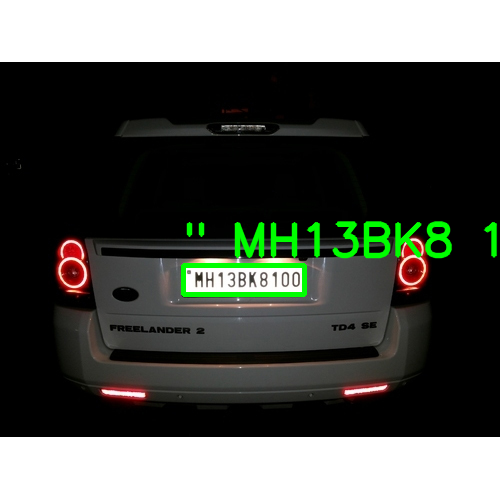

In [ ]:
import cv2
import pytesseract
import requests
import numpy as np
from google.colab.patches import cv2_imshow

# Function to preprocess the image
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(gray, 30, 200)
    return edged

# Function to find the plate contour
def find_plate_contour(edged):
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:30]
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.018 * perimeter, True)
        if len(approx) == 4:
            return approx
    return None

# Function to extract text from the plate
def extract_plate_text(image, contour):
    x, y, w, h = cv2.boundingRect(contour)
    plate_image = image[y:y + h, x:x + w]

    # Additional preprocessing to improve OCR accuracy
    plate_gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    _, plate_thresh = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    custom_config = r'--oem 3 --psm 7'  # Use a different OCR Engine mode and Page segmentation mode
    plate_text = pytesseract.image_to_string(plate_thresh, config=custom_config)

    return plate_text, (x, y, w, h)

# Main function
def main(image_url):
    # Load the image using requests
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)  # Convert to OpenCV image

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image.")
        return

    edged_image = preprocess_image(image)
    plate_contour = find_plate_contour(edged_image)

    if plate_contour is None:
        print("No contour detected that resembles a license plate.")
        return

    plate_text, (x, y, w, h) = extract_plate_text(image, plate_contour)
    print("Detected license plate number is:", plate_text.strip())

    cv2.putText(image, plate_text.strip(), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3, cv2.LINE_AA)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Show the image
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# URL to the image
image_url = 'https://5.imimg.com/data5/IE/WP/MY-13535092/orbiz-font-car-number-plate-1000x1000.jpg'
main(image_url)
